In [1]:
import os
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
batch_size = 200
n_batches = 300
max_address_len = 20
margin = 0.25
num_features = 50
dropout_keep_prob = 0.8

In [3]:
model = __import__('siamese_similarity_model')

In [4]:
def create_typo(s):
    rand_ind = random.choice(range(len(s)))
    s_list = list(s)
    s_list[rand_ind] = random.choice(string.ascii_lowercase + '0123456789')
    s = ''.join(s_list)
    return s

In [5]:
street_names = ['abbey', 'baker', 'canal', 'donner', 'elm', 'fifth',
                'grandvia', 'hollywood', 'interstate', 'jay', 'kings']
street_types = ['rd', 'st', 'ln', 'pass', 'ave', 'hwy', 'cir', 'dr', 'jct']
test_queries = ['111 abbey ln', '271 doner cicle', '314 king avenue',
                'tensorflow is fun']
test_references = ['123 abbey ln', '217 donner cir', '314 kings ave',
                   '404 hollywood st', 'tensorflow is so fun']

In [6]:
def get_batch(n):
    numbers = [random.randint(1, 9999) for i in range(n)]
    streets = [random.choice(street_names) for i in range(n)]
    street_suffs = [random.choice(street_types)]
    full_streets = [str(w) + ' ' + x + ' ' + y for w, x, y in
                    zip(numbers, streets, street_suffs)]
    typo_streets = [create_typo(x) for x in full_streets]
    reference = [list(x) for x in zip(full_streets, typo_streets)]
    
    half_ix = int(n / 2)
    bottom_half = reference[half_ix:]
    true_address = [x[0] for x in bottom_half]
    typo_address = [x[1] for x in bottom_half]
    typo_address = list(np.roll(typo_address, 1))
    bottom_half = [[x, y] for x, y in zip(reference, typo_address)]
    reference[half_ix:] = bottom_half
    
    target = [1] * (n - half_ix) + [-1] * half_ix
    reference = [[x, y] for x, y in zip(reference, target)]
    return reference

In [7]:
vocab_chars = string.ascii_lowercase + '0123456789 '
vocab2ix_dict = {char: (ix + 1) for ix, char in enumerate(vocab_chars)}
vocab_length = len(vocab_chars) + 1

def address2onehot(address, vocab2ix_dict=vocab2ix_dict, max_address_len=max_address_len):
    address_ix = [vocab2ix_dict[x] for x in list(address)]
    address_ix = (address_ix + [0] * max_address_len)[0:max_address_len]
    return address_ix

In [8]:
address1_ph = tf.placeholder(tf.int32, [None, max_address_len],
                             name='address1_ph')
address2_ph = tf.placeholder(tf.int32, [None, max_address_len],
                             name='address2_ph')
y_target_ph = tf.placeholder(tf.int32, [None], name='y_target_ph')
dropout_keep_prob_ph = tf.placeholder(tf.float32, name='dropout_keep_prob')

identity_mat = tf.diag(tf.ones(shape=[vocab_length]))
address1_embed = tf.nn.embedding_lookup(identity_mat, address1_ph)
address2_embed = tf.nn.embedding_lookup(identity_mat, address2_ph)

In [9]:
text_snn = model.snn(address1_embed, address2_embed, dropout_keep_prob_ph,
                     vocab_length, num_features, max_address_len)
batch_accuracy = model.accuracy(text_snn, y_target_ph)
batch_loss = model.loss(text_snn, y_target_ph, margin)
predictions = model.get_predictions(text_snn)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [10]:
optimizer = tf.train.AdamOptimizer(0.01)
train_op = optimizer.minimize(batch_loss)
init = tf.global_variables_initializer()

In [12]:
with tf.Session() as sess:
    sess.run(init)
    train_loss_vec = []
    train_acc_vec = []
    for b in range(n_batches):
        batch_data = get_batch(batch_size)
        np.random.shuffle(batch_data)
        input_addresses = [x[0] for x in batch_data]
        target_similarity = np.array([x[1] for x in batch_data])
        address1 = np.array([address2onehot(x[0]) for x in input_addresses])
        address2 = np.array([address2onehot(x[1]) for x in input_addresses])
        
        train_feed_dict = {
            address1_ph: address1,
            address2_ph: address2,
            y_target_ph: target_similarity,
            dropout_keep_prob_ph: dropout_keep_prob,
        }
        
        _, train_loss, train_acc = sess.run(
            [train_op, batch_loss, batch_accuracy], feed_dict=train_feed_dict
        )
        
        train_loss_vec.append(train_loss)
        train_acc_vec.append(train_acc)
        
    test_queries_ix = np.array([address2onehot(x) for x in test_queries])
    test_references_ix = np.array([address2onehot(x) for x in test_references])
    num_refs = test_references_ix.shape[0]
    best_fit_refs = []
    for query in test_queries_ix:
        test_query = np.repeat(np.array([query]), num_refs, axis=0)
        test_feed_dict = {
            address1_ph: test_query,
            address2_ph: test_references_ix,
            y_target_ph: target_similarity,
            dropout_keep_prob_ph: 1.0,
        }
        test_out = sess.run(text_snn, feed_dict=test_feed_dict)
        best_fit = test_references[np.argmax(test_out)]
        best_fit_refs.append(best_fit)
        
    print('Query Addresses: {}'.format(test_queries))
    print('Model Found Matches: {}'.format(best_fit_refs))

Query Addresses: ['111 abbey ln', '271 doner cicle', '314 king avenue', 'tensorflow is fun']
Model Found Matches: ['123 abbey ln', '217 donner cir', '314 kings ave', '217 donner cir']


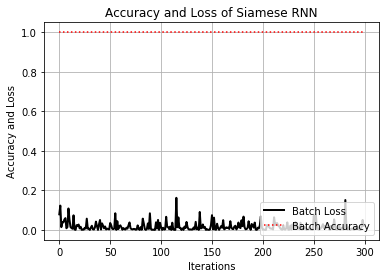

In [13]:
plt.plot(train_loss_vec, 'k-', lw=2, label='Batch Loss')
plt.plot(train_acc_vec, 'r:', label='Batch Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy and Loss')
plt.title('Accuracy and Loss of Siamese RNN')
plt.grid()
plt.legend(loc='lower right')
plt.show()